# DTCam

> Python module for capturing images from pre-determined addresses

In [ ]:
#| default_exp vision.dtcam

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from PIL import Image
from pathlib import Path
from io import BytesIO
from datetime import datetime
from typing import Optional

import json
import os
import requests

This utility focuses on capturing images from a weathercam provided by Road DigiTraffic based on its station location.

Road DigiTraffic provides data about public cameras from their weathercam stations, which includes information about its region name. Therefore, we can filter stations by their region name and find specific stations in a certain region (e.g., Helsinki, Porvoo, ...).

In [ ]:
#| export
stations_url = "https://tie.digitraffic.fi/api/weathercam/v1/stations"

## Camera address book

First, we can build an address book of camera installed address, and image capture url from Road DigiTraffic. The format of this address book can be a list of JSON-formatted data objects:
```
[
    {
        "address": <camera installed location>,
        "url": <capture image url>,
    },
    {
        "address": <camera installed location>,
        "url": <capture image url>,
    },
    ....
]
```

In [ ]:
#| export
def build_address_book(stations_url:str):
    table = []
    stations = requests.get(stations_url).json()['features']
    for station in stations:
        station = requests.get(stations_url+'/'+station['id']).json().get('properties')
        if not station:
            continue
        for preset in station['presets']:
            try:
                addr = ",".join([preset['presentationName'], station['names'].get('fi'), station['municipality'], station['province']])
            except:
                continue
            info = {
                #"id": preset['id'],
                "address": addr,
                "url": preset['imageUrl'],
            }
            table.append(info)
    return table

In [ ]:
#| export
def address_book(stations_url:str=stations_url, force_update=False):
    """Get an address book [{"address":<camera installed address>, "url":<image capture url>}]"""
    # Attempt to load from cache
    if not force_update and os.path.exists("preset_image_url.json"):
        with open("preset_image_url.json", "r") as f:
            return json.load(f)
        
    # Build and cache
    data = build_address_book(stations_url)
    with open("preset_image_url.json", "w") as f:
        json.dump(data, f, indent=4) 
    return data

In [ ]:
#| export
def camera_address_book(
    stations_url: Optional[str] = stations_url,  # Weather Camera URL
    update: Optional[bool] = False,  # Update addressbook forcely
) -> str:  # List of `"camera location"`:`"image url"`
    """Get weather camera location addressbook of `camera location`:`image url`. You can get an capture of camera from this url"""   
    data = address_book(stations_url, update)
    return json.dumps(data)

Example address book from Road DigiTraffic:

In [ ]:
#| eval: false
addresses = camera_address_book()
json.loads(addresses)[0]

{'address': 'Porvoo,Tie 7 Porvoo, Harabacka,Porvoo,Uusimaa',
 'url': 'https://weathercam.digitraffic.fi/C0150200.jpg'}

## Weathercam image capturing

Based on possible weathercam stations, we extract images from these cameras by requesting the corresponding URL:

In [ ]:
#| export
def stations(key:str)->list[dict]:
    """"Get all weather station including `key` word"""
    # Get all weather stations
    res = requests.get(stations_url)
    assert res.status_code == 200, f"Failed to get stations with status code {res.status_code}"

    # Filter stations by region name
    stations = res.json()['features']
    return [st for st in stations if key.lower() in st['properties']['name'].lower()]

Example with finding stations in Porvoo:

In [ ]:
Porvoos = stations("Porvoo")
Porvoos[0]

{'type': 'Feature',
 'id': 'C01502',
 'geometry': {'type': 'Point', 'coordinates': [25.616391, 60.390238, 0.0]},
 'properties': {'id': 'C01502',
  'name': 'vt7_Porvoo_Harabacka',
  'collectionStatus': 'GATHERING',
  'state': None,
  'dataUpdatedTime': '2024-12-12T03:26:57Z',
  'presets': [{'id': 'C0150200', 'inCollection': True}]}}

In [ ]:
#| hide
assert "porvoo" in Porvoos[0]['properties']['name'].lower()

For DigiTraffic, the image from a weather camera can be retrieved with a weathercam URL using the `presets` data:

In [ ]:
#| export
def presets(station:dict)->list[dict]:
    """Get all presets at a given weather station"""
    # Get information about one station with station ID
    res = requests.get(stations_url + "/" + station['id'])
    assert res.status_code == 200, f"Failed to get presets {res.status_code}"
    
    # Get presets data
    presets = res.json()['properties']['presets']
    return presets

In [ ]:
preset = presets(Porvoos[0])[0]
imageUrl = preset['imageUrl']
imageUrl

'https://weathercam.digitraffic.fi/C0150200.jpg'

In [ ]:
#| hide
assert "jpg" in imageUrl

Download and save this image to local disk:

In [ ]:
#| export
def capture(preset:dict)->Path:
    """Capture image at a given preset location in a Weather station, and return an image path"""
    # Get image from the preset
    req = requests.get(preset['imageUrl'], headers={'Digitraffic-User': 'NinjaLABO/LLMCAM 1.0'})
    assert req.status_code == 200, f"Failed to get image {req.status_code}"
    
    # Save image to a file
    img = Image.open(BytesIO(req.content))
    dt = datetime.strptime(req.headers["last-modified"], '%a, %d %b %Y %H:%M:%S %Z')
    dtstr = dt.strftime("%Y.%m.%d_%H:%M:%S")
    dir = os.getenv("LLMCAM_DATA", "../data")
    path = f"{dir}/cap_{dtstr}_{preset['presentationName']}_{preset['id']}.jpg"
    img.save(path, format="JPEG")

    # Return request header and image path
    return req.headers, path

In [ ]:
#| eval: false
hdr, path = capture(preset)
hdr

{'Content-Type': 'image/jpeg', 'Content-Length': '66682', 'Connection': 'keep-alive', 'x-amz-id-2': 'e1nXLX4h6A1+r45u0fdlv7R44L3NqThwbK0/xJ7cUHnPUzkR6z4GhW5s0HhjppQttrBA0mLj+DoGPEfuI5ARaQ==', 'x-amz-request-id': '7YJ7D76VBEJA18S2', 'last-modified': 'Thu, 12 Dec 2024 13:03:04 GMT', 'x-amz-expiration': 'expiry-date="Sat, 14 Dec 2024 00:00:00 GMT", rule-id="Delete versions and current images after 24h"', 'x-amz-server-side-encryption': 'AES256', 'X-Amz-Meta-Last-Modified': 'Thu, 12 Dec 2024 13:03:04 GMT', 'x-amz-version-id': 'MbujShinwFlbCASbDJ4XE957WpwwBYT4', 'Accept-Ranges': 'bytes', 'Server': 'AmazonS3', 'Date': 'Thu, 12 Dec 2024 13:10:19 GMT', 'ETag': '"1c38821750ddec3363436dcd1077eb83"', 'Vary': 'Accept-Encoding', 'X-Cache': 'Hit from cloudfront', 'Via': '1.1 95ad0c949c0fe7e97075c6690b8574aa.cloudfront.net (CloudFront)', 'X-Amz-Cf-Pop': 'HEL51-P1', 'Alt-Svc': 'h3=":443"; ma=86400', 'X-Amz-Cf-Id': 'p4oSYL7h9m8R9Xua8kSJe59PlJJuqITUAx_V5e9urJ3GJSoAzOEu_w==', 'Age': '54'}

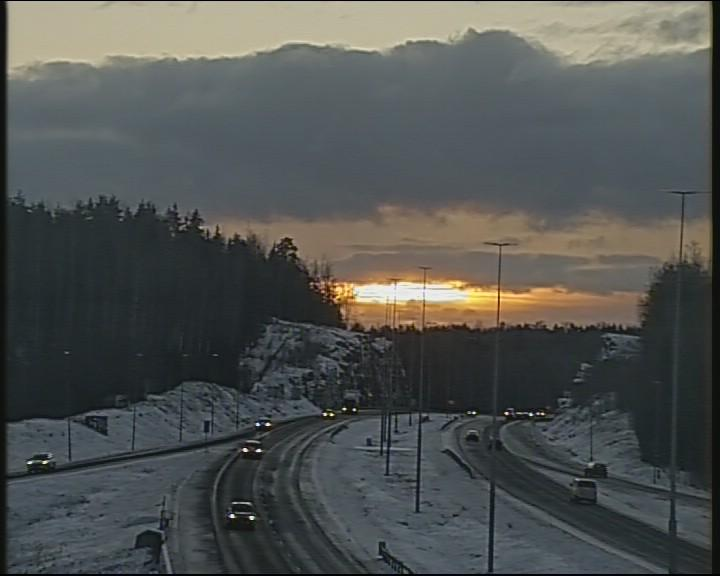

In [ ]:
#| eval: false
display(Image.open(path))

We can all previous utilities and implement a function that capture images based on location keyword:

In [ ]:
#| export
def cap(
    key: str = "Porvoo",  # Location keyword
) -> str:  # Image path
    """Capture an image at specified location, save it, and return its path"""
    _, path = capture(presets(stations(key)[0])[0])
    return str(path)

In [ ]:
show_doc(cap)

---

[source](https://github.com/ninjalabo/llmcam/blob/main/llmcam/vision/dtcam.py#L59){target="_blank" style="float:right; font-size:smaller"}

### cap

>      cap (key:str='Porvoo')

*Capture an image at specified location, save it, and return its path*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| key | str | Porvoo | Location keyword |
| **Returns** | **str** |  | **Image path** |

## Simulated GPT workflow

This section tests integrating with our current GPT framework. This function can be used in combination with previous functions in the `vision` module:

In [ ]:
#| eval: false
#| eval: false
from llmcam.core.fc import *
from llmcam.core.fn_to_schema import function_schema
from llmcam.vision.ytlive import capture_youtube_live_frame
from llmcam.vision.gpt4v import ask_gpt4v_about_image_file
from llmcam.vision.yolo import detect_objects

tools = [
    function_schema(capture_youtube_live_frame, "Youtube Live Capture"),
    function_schema(ask_gpt4v_about_image_file, "GPT4 Vision"),
    function_schema(detect_objects, "YOLO Object Detection"),
    function_schema(camera_address_book, "Weather Camera Address Book"),
    function_schema(cap, "Weather Station Capture")
]
messages = form_msgs([
    ("system", "You are a helpful system administrator. Use the supplied tools to assist the user."),
    ("user", "Name some locations to capture weather station images from the default address book."),
])
complete(messages, tools=tools)
print_msgs(messages)

>> System:
You are a helpful system administrator. Use the supplied tools to assist the user.
>> User:
Name some locations to capture weather station images from the default address book.
>> Assistant:
Here are some locations from the default weather camera address book where you can capture images:
1. Porvoo, Uusimaa - [Link](https://weathercam.digitraffic.fi/C0150200.jpg) 2. Inkoo, Uusimaa -
[Link](https://weathercam.digitraffic.fi/C0150301.jpg) 3. Hanko, Uusimaa -
[Link](https://weathercam.digitraffic.fi/C0150302.jpg) 4. Karkkila, Uusimaa -
[Link](https://weathercam.digitraffic.fi/C0150401.jpg) 5. Helsinki, Uusimaa -
[Link](https://weathercam.digitraffic.fi/C0150402.jpg) 6. Lohja, Uusimaa -
[Link](https://weathercam.digitraffic.fi/C0150601.jpg) 7. Hanko, Uusimaa -
[Link](https://weathercam.digitraffic.fi/C0150701.jpg) 8. Mäntsälä, Uusimaa -
[Link](https://weathercam.digitraffic.fi/C0150801.jpg) 9. Hyvinkää, Uusimaa -
[Link](https://weathercam.digitraffic.fi/C0150901.jpg) 10. Vantaa,

In [ ]:
#| eval: false
# Continue the conversation and ask the user about the image
messages.append(form_msg("user", "Capture a weather station image from Helsinki and tell me some basic information about it."))
complete(messages, tools=tools)
print_msgs(messages)

>> System:
You are a helpful system administrator. Use the supplied tools to assist the user.
>> User:
Name some locations to capture weather station images from the default address book.
>> Assistant:
Here are some locations from the default weather camera address book where you can capture images:
1. Porvoo, Uusimaa - [Link](https://weathercam.digitraffic.fi/C0150200.jpg) 2. Inkoo, Uusimaa -
[Link](https://weathercam.digitraffic.fi/C0150301.jpg) 3. Hanko, Uusimaa -
[Link](https://weathercam.digitraffic.fi/C0150302.jpg) 4. Karkkila, Uusimaa -
[Link](https://weathercam.digitraffic.fi/C0150401.jpg) 5. Helsinki, Uusimaa -
[Link](https://weathercam.digitraffic.fi/C0150402.jpg) 6. Lohja, Uusimaa -
[Link](https://weathercam.digitraffic.fi/C0150601.jpg) 7. Hanko, Uusimaa -
[Link](https://weathercam.digitraffic.fi/C0150701.jpg) 8. Mäntsälä, Uusimaa -
[Link](https://weathercam.digitraffic.fi/C0150801.jpg) 9. Hyvinkää, Uusimaa -
[Link](https://weathercam.digitraffic.fi/C0150901.jpg) 10. Vantaa,

In [ ]:
#| eval: false
# Continue the conversation and detect objects in the image
messages.append(form_msg("user", "Can you detect what objects are captured in this image?"))
complete(messages, tools=tools)
print_msgs(messages)


image 1/1 /home/nghivo/tinyMLaaS/llmcam/data/cap_2024.12.12_13:06:53_Kehä 1 Itään_C0151301.jpg: 384x640 7 cars, 54.9ms
Speed: 5.5ms preprocess, 54.9ms inference, 221.6ms postprocess per image at shape (1, 3, 384, 640)
>> System:
You are a helpful system administrator. Use the supplied tools to assist the user.
>> User:
Name some locations to capture weather station images from the default address book.
>> Assistant:
Here are some locations from the default weather camera address book where you can capture images:
1. Porvoo, Uusimaa - [Link](https://weathercam.digitraffic.fi/C0150200.jpg) 2. Inkoo, Uusimaa -
[Link](https://weathercam.digitraffic.fi/C0150301.jpg) 3. Hanko, Uusimaa -
[Link](https://weathercam.digitraffic.fi/C0150302.jpg) 4. Karkkila, Uusimaa -
[Link](https://weathercam.digitraffic.fi/C0150401.jpg) 5. Helsinki, Uusimaa -
[Link](https://weathercam.digitraffic.fi/C0150402.jpg) 6. Lohja, Uusimaa -
[Link](https://weathercam.digitraffic.fi/C0150601.jpg) 7. Hanko, Uusimaa -
[Li

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()